In [1]:
%pip install --quiet -U langgraph langchain_core langchain_community langchain_ollama pillow

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.12.1 requires pyarrow<16,>=4.0.0, but you have pyarrow 20.0.0 which is incompatible.
mlflow 2.12.1 requires pytz<2025, but you have pytz 2025.2 which is incompatible.
streamlit 1.38.0 requires pillow<11,>=7.1.0, but you have pillow 11.2.1 which is incompatible.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [3]:
from PIL import Image, ImageGrab
from io import BytesIO
import base64
from typing import Optional, List, Dict

def image_to_base64(
    image_input: Optional[Image.Image] = None,
    file_path: Optional[str] = None,
    format: str = "JPEG"
) -> Optional[str]:
    try:
        if image_input is None and file_path is None:
            image_input = ImageGrab.grabclipboard()
            if image_input is None:
                print("Clipboard does not contain an image.")
                return None
            if image_input.mode != 'RGB':
                image_input = image_input.convert('RGB')
                
        if file_path is not None:
            try:
                image_input = Image.open(file_path)
            except FileNotFoundError:
                raise FileNotFoundError(f"Image file not found: {file_path}")
            except Exception as e:
                raise ValueError(f"Failed to open image file: {str(e)}")

        if not isinstance(image_input, Image.Image):
            raise ValueError("Invalid image input type")

        image_resized = image_input.resize((400, 500))
        display(image_resized)

        buffered = BytesIO()
        image_input.convert('RGB').save(buffered, format=format)
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        return img_str

    except Exception as e:
        raise ValueError(f"Failed to convert image to base64: {str(e)}")

In [4]:
def format_message(
    text: str,
    default_format: str = "JPEG"
) -> List[Dict[str, str]]:

    content = []
    image = None
    try:
        message_text = text

        content.append({"type": "text", "text": message_text})
        
        if "#keyboard" in text:
            image = image_to_base64(format=default_format)
            message_text = text.replace("#keyboard", "").strip()
            
        elif "#path:" in text:
            try:
                tag_start = text.find("#path:")
                tag_end = text.find(" ", tag_start)
                if tag_end == -1: 
                    tag_end = len(text)
                
                path = text[tag_start + 6:tag_end].strip()
                message_text = text[:tag_start] + text[tag_end:].strip()
                
                image = image_to_base64(file_path=path, format=default_format)
            except Exception as e:
                raise ValueError(f"Failed to process path: {str(e)}")

        if image is not None:
            content.append({
                "type": "image_url",
                "image_url": f"data:image/{default_format.lower()};base64,{image}"
            })


        return content

    except Exception as e:
        return [{"type": "text", "text": f"{text} (Image processing failed: {str(e)})"}]

In [20]:
from langchain_ollama import ChatOllama

model = ChatOllama(
        base_url="http://localhost:11434",
        model="llama3.2-vision",
        # model="llava:7b",
        temperature=0,
        streaming=True
    )

In [21]:
prompt = (
    """
    AI Assistant Guidelines for Image Analysis and Response:
    
    1. Image and Knowledge Protocol:
       - Focus on delivering accurate, objective descriptions of visual elements based on the image provided.
       - If text is present in the image, extract it precisely and provide it as-is without speculation or interpretation.
       - Do not make assumptions about elements outside the visible content of the image.
    
    2. Response Quality:
       - Provide clear, well-structured responses, integrating extracted text or observations without extrapolation.
       - If instructions are unclear or outside image capabilities, inform the user promptly and professionally.
    
    3. Communication Style:
       - Maintain a formal, respectful tone, organizing observations and insights logically for clarity.
    
    4. Error Handling:
       - Acknowledge limitations or ambiguities in the image content.
       - Avoid speculating about any unclear or missing details.
       - Request clarification if the user's instructions are insufficient or ambiguous.
    
    5. Text Extraction Focus:
       - Prioritize accurate transcription of all visible text from images.
       - Do not interpret, analyze, or draw conclusions about the extracted text unless explicitly requested.
    
    6. Follow-Up:
       - Be ready to explain or provide additional insights on the extracted text or specific visual elements as requested by the user.
    """
)

In [22]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", prompt),
    ("placeholder", "{message}")
])

In [23]:
def call_model(state: MessagesState):
    formated_promt = prompt.format(message=state["messages"])
    message = [{"role": "system", "content": formated_promt}] + state["messages"]
    return {"messages": [model.invoke(message)]}

In [24]:
def message_format(state: MessagesState):
    try:
        message = state['messages'][-1].content
        formated_message = format_message(message)
        
        return {"messages": [HumanMessage(content=formated_message)]}
    except Exception as e:
        print(f"Message formatting error: {e}")
        return {"messages": state['messages']}


In [25]:
memory = MemorySaver()
builder = StateGraph(MessagesState)

builder.add_node("message_format", message_format)
builder.add_node("call_model", call_model)

builder.add_edge(START, "message_format")
builder.add_edge("message_format", "call_model")
builder.add_edge("call_model", END)

graph = builder.compile(checkpointer=memory)

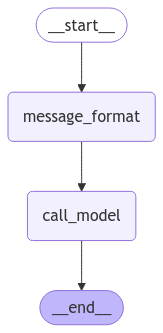

In [26]:
from IPython.display import Image as IPythonImage
from IPython.display import display


try:
    display(IPythonImage(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [27]:
import uuid
thread_id = str(uuid.uuid4())

config = {"configurable": {"user_id": "vision assistance", "thread_id": thread_id}}

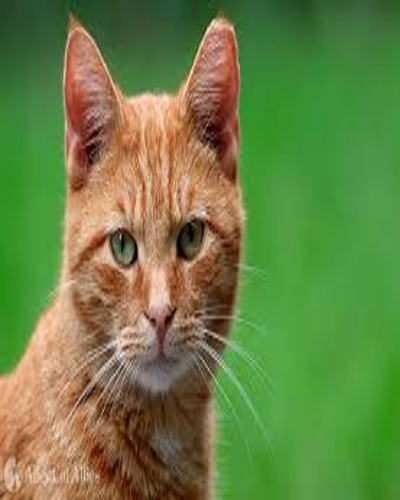

================================== Ai Message ==================================

The image shows a cat. The cat is orange with white markings on its face and chest. It has green eyes and pointy ears. The background of the image is blurry, but it appears to be a natural setting, possibly outdoors.

Here are some key features of the image:

* **Cat:** 
	+ Color: Orange
	+ White markings: On the face and chest
	+ Eyes: Green
	+ Ears: Pointy
* **Background:** 
	+ Blurry
	+ Natural setting

Overall, the image is a close-up shot of an orange cat with white markings on its face and chest. The background is blurry, but it appears to be a natural setting, possibly outdoors.


In [28]:
for chunk in graph.stream({
    "messages": HumanMessage(content="what is on the following image? #path:./images.jpeg")
}, stream_mode="values", config=config):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        if isinstance(last_message, AIMessage):
            last_message.pretty_print()

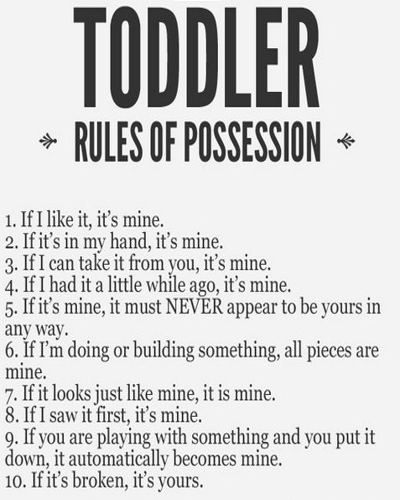

================================== Ai Message ==================================

The image shows a list of 10 rules for toddlers, titled "TODDLER RULES OF POSSESSION". The rules are as follows:

1. If I like it, it's mine.
2. If it's in my hand, it's mine.
3. If I can take it from you, it's mine.
4. If I had it a little while ago, it's mine.
5. If it's mine, it must never appear to be yours again.
6. If I'm doing or building something, all the pieces are mine.
7. If it looks like mine, it's mine.
8. If I saw it first, it's mine.
9. If you're playing with it and put it down, it's mine.
10. If it gets broken, it's definitely mine.

These rules are humorous and relatable to parents of toddlers, as they often struggle with sharing toys and possessions with their little ones.


In [29]:
for chunk in graph.stream({
    "messages": HumanMessage(content="list all the rules on the image? #path:./4c153fad-2a4b-47a2-9ae4-c1d8913c6381.jpeg")
}, stream_mode="values", config=config):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        if isinstance(last_message, AIMessage):
            last_message.pretty_print()

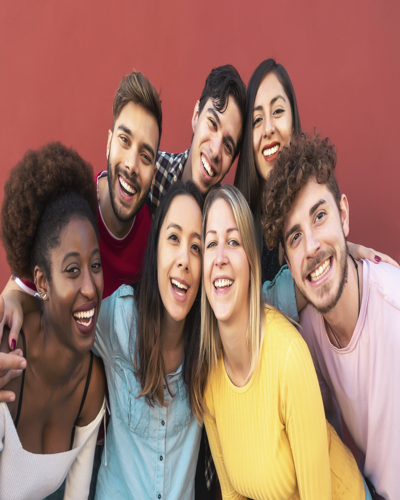

================================== Ai Message ==================================

Let's take a look at the image. I can see that there are several people present, but it's difficult to give an exact count without more information. However, based on what I can see, it appears that there are at least 7-8 individuals in the image.

Here are some observations:

* There is a group of young adults posing together.
* They appear to be friends or acquaintances.
* Some of them are smiling and looking directly at the camera.
* Others are looking away or have their eyes closed.

Overall, it seems that there are around 7-8 people in the image. However, without more context or information, it's difficult to provide an exact count.


In [30]:
for chunk in graph.stream({
    "messages": HumanMessage(content="How many people are present in the image? tell me more #path:./XaHpf_z51huQS_JPHs-jkPhBp0dLlxFJwt-sPLpGJB0.jpg")
}, stream_mode="values", config=config):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        if isinstance(last_message, AIMessage):
            last_message.pretty_print()

In [ ]:
# Locate an image and copy it before executing the following code.
for chunk in graph.stream({
    "messages": HumanMessage(content="Could you provide a description of the image? #keyboard")
}, stream_mode="values", config=config):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        if isinstance(last_message, AIMessage):
            last_message.pretty_print()